In [77]:
import cnn_limits.notebook
import imp
imp.reload(cnn_limits.notebook)

from cnn_limits.notebook import ExperimentResults, el, plot_df

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import collections

In [312]:
m10_v2_paths = [
    "robbins:/scratch/ag919/logs/kernel_plus_learn/9",
    "robbins:/scratch/ag919/logs/kernel_plus_learn/10",
    "robbins:/scratch/ag919/logs/kernel_plus_learn/11",
    "sagarmatha:/scratch/ag919/logs/kernel_plus_learn/5",
]
for i in [12, 13, *range(30, 34), *range(37, 44), *range(70, 81), *range(82, 86)]:
    # 82-86: just looking at lengthscale 1.7
    m10_v2_paths.append(f"thom:/scratch/ag919/logs/kernel_plus_learn/{i}")
for i in [*range(33, 36)]:
    m10_v2_paths.append(f"huygens:/scratch/ag919/logs/kernel_plus_learn/{i}")
    

m10_v3_paths = []
for i in range(50, 59):
    m10_v3_paths.append(f"thom:/scratch/ag919/logs/kernel_plus_learn/{i}")
for i in [*range(20, 26), *range(41, 47)]:
    m10_v3_paths.append(f"poisson:/scratch/ag919/logs/kernel_plus_learn/{i}")
for i in range(23, 32):
    m10_v3_paths.append(f"huygens:/scratch/ag919/logs/kernel_plus_learn/{i}")
for i in [*range(18, 24), *range(25, 31), *range(32, 37)]:
    m10_v3_paths.append(f"robbins:/scratch/ag919/logs/kernel_plus_learn/{i}")
for i in [*range(8, 17), *range(35, 42)]:
    m10_v3_paths.append(f"laplace:/tmp/ag919/logs/kernel_plus_learn/{i}")
for i in range(7, 10):
    m10_v3_paths.append(f"sagarmatha:/scratch/ag919/logs/kernel_plus_learn/{i}")
for i in range(8, 11):
    m10_v3_paths.append(f"stroustrup:/scratch/ag919/logs/kernel_plus_learn/{i}")

m10_v1_paths = [
    "poisson:/scratch/ag919/logs/kernel_plus_learn/2",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/3",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/9",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/10",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/11",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/12",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/13",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/14",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/15",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/16",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/17",
    "poisson:/scratch/ag919/logs/kernel_plus_learn/18",
    
    "huygens:/scratch/ag919/logs/kernel_plus_learn/15",
    "huygens:/scratch/ag919/logs/kernel_plus_learn/16",
    "huygens:/scratch/ag919/logs/kernel_plus_learn/18",
    "huygens:/scratch/ag919/logs/kernel_plus_learn/19",
    "huygens:/scratch/ag919/logs/kernel_plus_learn/20",
    "huygens:/scratch/ag919/logs/kernel_plus_learn/21",
    "huygens:/scratch/ag919/logs/kernel_plus_learn/22",
    
    
    "robbins:/scratch/ag919/logs/kernel_plus_learn/13",
    "robbins:/scratch/ag919/logs/kernel_plus_learn/14",
    "robbins:/scratch/ag919/logs/kernel_plus_learn/15",
    "robbins:/scratch/ag919/logs/kernel_plus_learn/16",
    "robbins:/scratch/ag919/logs/kernel_plus_learn/17",
]


m10_vanilla_paths = [
    "robbins:/scratch/ag919/logs/predict_cv_acc/19",
    "robbins:/scratch/ag919/logs/predict_cv_acc/20",
    "robbins:/scratch/ag919/logs/predict_cv_acc/21",
    "robbins:/scratch/ag919/logs/predict_cv_acc/22",
    "robbins:/scratch/ag919/logs/predict_cv_acc/23",
    "banach:/scratch/ag919/logs/predict_cv_acc/12",
    "banach:/scratch/ag919/logs/predict_cv_acc/13",
    "banach:/scratch/ag919/logs/predict_cv_acc/14",
    "banach:/scratch/ag919/logs/predict_cv_acc/15",
]

m10_v4_paths = []
for i in range(28, 39):
    m10_v4_paths.append(f"poisson:/scratch/ag919/logs/kernel_plus_learn/{i}")
for i in range(22, 34):
    m10_v4_paths.append(f"laplace:/tmp/ag919/logs/kernel_plus_learn/{i}")
for i in range(1, 7):
    m10_v4_paths.append(f"stroustrup:/scratch/ag919/logs/kernel_plus_learn/{i}")



In [333]:
def build_sweep(paths, model_name, append_dir=None, skip_incomplete=True):    
    def make_df(df):
        index = np.copy(df.index)
        columns = np.copy(df.columns)
        return pd.DataFrame(columns=columns, index=index,
                            data=np.zeros((len(index), len(columns))))
    means = collections.defaultdict(lambda: None, {})
    vars = collections.defaultdict(lambda: None, {})
    Ns = collections.defaultdict(lambda: 0, {})

    for p in paths:
        with ExperimentResults(p, "").open("config.json") as f:
            config = json.load(f)
        try:
            a = config['save_new']
            lscale = float(config['save_new']['internal_lengthscale'])

        except KeyError:
            # Go to the experiment this was using
            new = ExperimentResults(f"{ExperimentResults(p, '').host}:{config['kernel_matrix_path']}", "")
            with new.open("config.json") as f:
                a = json.load(f)
                
            lscale = None
        assert a['model'] == model_name, f"path {p} is not using model {model_name}"

        if abs(lscale - 3.758374) < 1e-6:
            lscale = 3.758374  # Prevent separation of various lscales
        
        if append_dir is not None:
            p = os.path.join(p, append_dir)
        try:
            loo_acc_df = ExperimentResults(p, "").read_pickle("grid_acc.pkl.gz")
        except FileNotFoundError:
            raise FileNotFoundError(p + "/grid_acc.pkl.gz")
        if skip_incomplete and not loo_acc_df.dropna().equals(loo_acc_df):
            print(f"Skipping {p} because it is incomplete")
            continue
        else:
            loo_acc_df = loo_acc_df.dropna()
        loo_acc_df = loo_acc_df.applymap(lambda x: np.max(x[1]))
        
        mean = means[lscale]
        var = vars[lscale]
        
        if mean is None or var is None:
            mean = make_df(loo_acc_df)
            var = make_df(loo_acc_df)
        
        mean += loo_acc_df
        var += loo_acc_df**2
        
        means[lscale] = mean
        vars[lscale] = var
        Ns[lscale] += 1
    return means, vars, Ns

def _one_plottable_sweep(mean, var, N):
    mean = mean/N
    if N == 1:
        N_1 = 1
    else:
        N_1 = (N-1)
    var = (var/N - mean**2) * (N/N_1)  # Unbiased variance
    error = 2*(var/N)**.5
    return mean, error

def plottable_sweep(means, vars, Ns):
    df = pd.DataFrame(columns=[2**i * 10 for i in range(9)])
    df_e = pd.DataFrame(columns=[2**i * 10 for i in range(9)])
    for ls in means.keys():
        m, e = _one_plottable_sweep(means[ls], vars[ls], Ns[ls])
        # ignore e TODO stop ignoring it
        arg = m.idxmax(axis=0).loc[1280]
        #acc_max = m.max(axis=0)
        acc_max = m.loc[arg, :]
        err_max = e.loc[arg, :]
        #acc_max = m.iloc[-1, :]
        #err_max = e.iloc[-1, :]
        df.loc[ls, :] = acc_max
        df_e.loc[ls, :] = err_max
    return df.sort_index(), df_e.sort_index()

def plot_sweep_df(df, err, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 10))
    df.plot(ax=ax, yerr=err)
    ax.set_ylabel("4-fold cross-validation accuracy, with mean-pooling in the end")
    ax.set_xlabel("lengthscale of Matérn-3/2 kernel")
    return ax

In [347]:
args_v2[0][1.].idxmax(axis=0)

10        0
20        0
40       61
80      101
160      34
320      48
640      40
1280     79
dtype: int64

In [290]:
args_v1 = build_sweep(m10_v1_paths, 'Myrtle10_replaced_tick_v1_sweep', "n_splits_4")

Skipping poisson:/scratch/ag919/logs/kernel_plus_learn/3/n_splits_4 because it is incomplete


In [334]:
tick_v1_df, tick_v1_err = plottable_sweep(*args_v1)

In [324]:
args_v2 = build_sweep(m10_v2_paths, 'Myrtle10_replaced_tick_v2_sweep', "n_splits_4")

Skipping thom:/scratch/ag919/logs/kernel_plus_learn/13/n_splits_4 because it is incomplete


In [335]:
tick_v2_df, tick_v2_err = plottable_sweep(*args_v2)

In [314]:
args_v3 = build_sweep(m10_v3_paths, 'Myrtle10_replaced_tick_v3_sweep', "n_splits_4", skip_incomplete=False)

In [336]:
tick_v3_df, tick_v3_err = plottable_sweep(*args_v3)

In [296]:
args_v4 = build_sweep(m10_v4_paths, 'Myrtle10_replaced_tick_v4_sweep', "n_splits_4")

In [337]:
tick_v4_df, tick_v4_err = plottable_sweep(*args_v4)

In [298]:
args_myrtle10 = build_sweep(m10_vanilla_paths, 'Myrtle10_sweep')

In [339]:
myrtle10_df, myrtle10_err = plottable_sweep(*args_myrtle10)

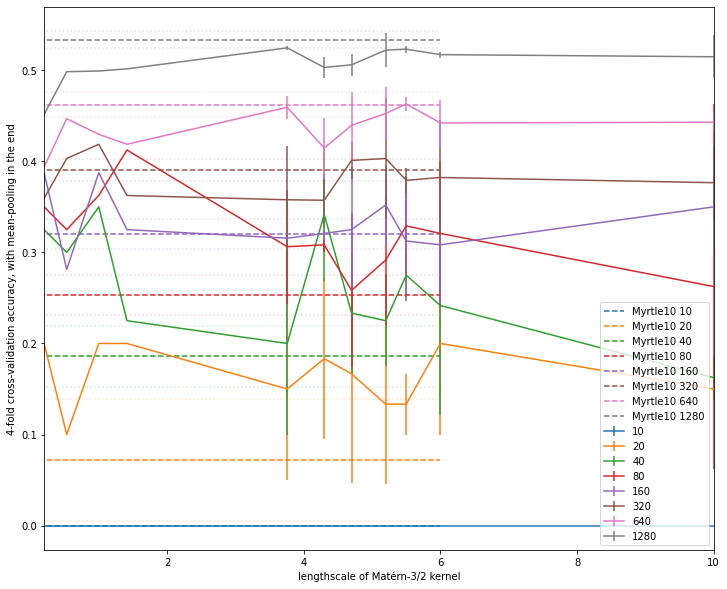

In [340]:
ax = plot_sweep_df(tick_v1_df.loc[:, :1280], tick_v1_err.loc[:, :1280])

for j, (i, v) in enumerate(myrtle10_df.iloc[0, :].items()):
    if not np.isnan(v):
        e = myrtle10_err.iloc[0, j]
        line, = ax.plot([-3, 6], [v, v], linestyle='--', label=f"Myrtle10 {i}", color=f"C{j}")  
        ax.plot([-3, 6], [v+e, v+e], linestyle=':', alpha=0.2, color=line.get_color())
        ax.plot([-3, 6], [v-e, v-e], linestyle=':', alpha=0.2, color=line.get_color())   
ax.legend()

In [301]:
myrtle10_df

,10,20,40,80,160,320,640,1280,2560
NaN,0,0.0722222,0.186111,0.252778,0.320833,0.389931,0.462326,0.532639,NaN


In [322]:
args_v2[0].keys()

dict_keys([0.19952623, 0.53088444, 1.41253754, 1.0, 3.75837404, 1.7, 1.85, 2.0, 2.15, 2.3, 2.6, 3.0, 1.65, 1.75, 1.8, 3.758374, 4.5])

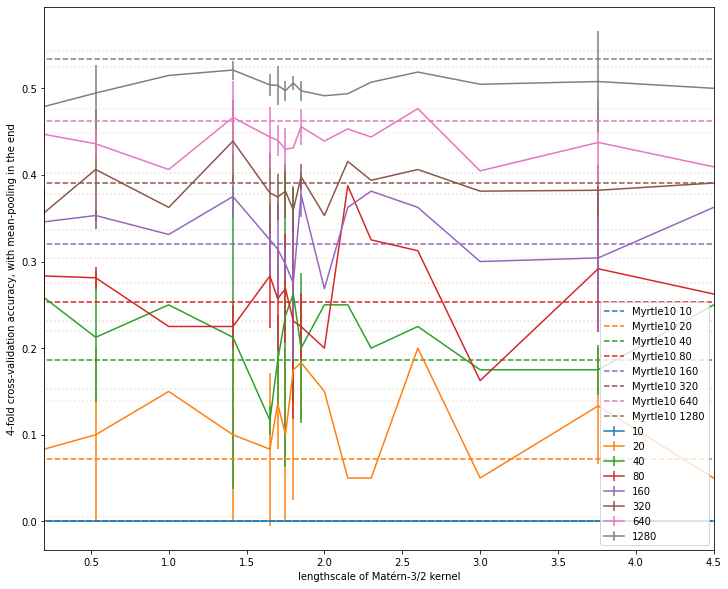

In [341]:
ax = plot_sweep_df(tick_v2_df.loc[:, :1280], tick_v2_err.loc[:, :1280])

for j, (i, v) in enumerate(myrtle10_df.iloc[0, :].items()):
    if not np.isnan(v):
        e = myrtle10_err.iloc[0, j]
        line, = ax.plot([-3, 6], [v, v], linestyle='--', label=f"Myrtle10 {i}", color=f"C{j}")  
        ax.plot([-3, 6], [v+e, v+e], linestyle=':', alpha=0.2, color=line.get_color())
        ax.plot([-3, 6], [v-e, v-e], linestyle=':', alpha=0.2, color=line.get_color())
ax.legend()

In [288]:
args_v3[2]

defaultdict(<function __main__.build_sweep.<locals>.<lambda>()>,
            {1.65: 6,
             1.7: 5,
             1.75: 5,
             1.8: 5,
             1.85: 3,
             1.9: 2,
             2.0: 4,
             2.1: 3,
             2.3: 3,
             0.2: 2,
             0.5: 2,
             0.7: 2,
             1.0: 1,
             1.3: 1,
             1.5: 1})

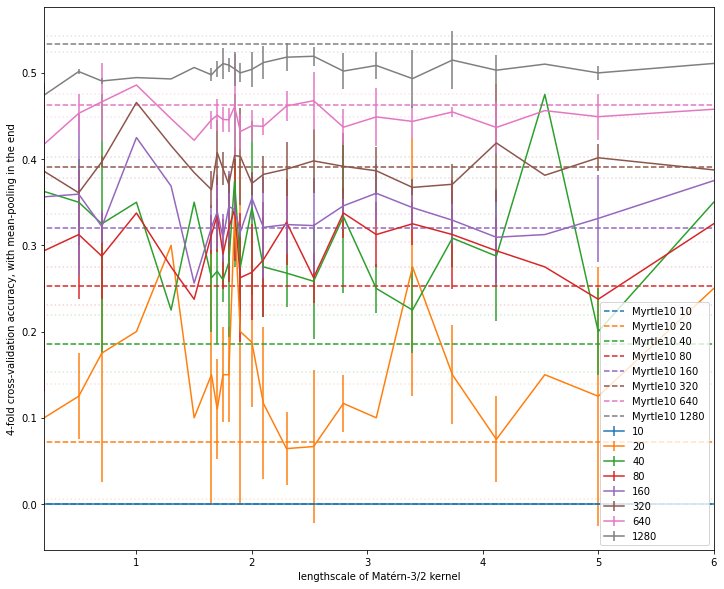

In [343]:
ax = plot_sweep_df(tick_v3_df.loc[:, :1280], tick_v3_err.loc[:, :1280])

for j, (i, v) in enumerate(myrtle10_df.iloc[0, :].items()):
    if not np.isnan(v):
        e = myrtle10_err.iloc[0, j]
        line, = ax.plot([-3, 6], [v, v], linestyle='--', label=f"Myrtle10 {i}", color=f"C{j}")  
        ax.plot([-3, 6], [v+e, v+e], linestyle=':', alpha=0.2, color=line.get_color())
        ax.plot([-3, 6], [v-e, v-e], linestyle=':', alpha=0.2, color=line.get_color())   
ax.legend()

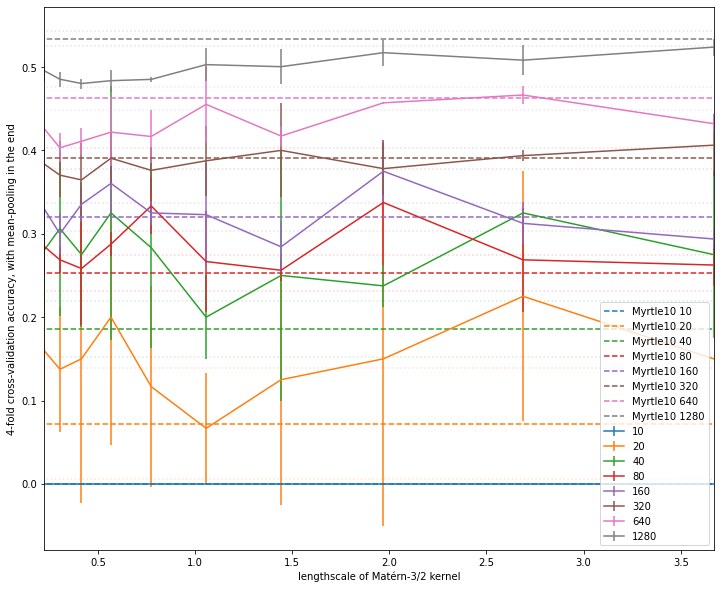

In [344]:
ax = plot_sweep_df(tick_v4_df.loc[:, :1280], tick_v4_err.loc[:, :1280])

for j, (i, v) in enumerate(myrtle10_df.iloc[0, :].items()):
    if not np.isnan(v):
        e = myrtle10_err.iloc[0, j]
        line, = ax.plot([-3, 6], [v, v], linestyle='--', label=f"Myrtle10 {i}", color=f"C{j}")  
        ax.plot([-3, 6], [v+e, v+e], linestyle=':', alpha=0.2, color=line.get_color())
        ax.plot([-3, 6], [v-e, v-e], linestyle=':', alpha=0.2, color=line.get_color())   
ax.legend()

In [196]:
np.linspace(1.6, 2.0, 4)

array([1.6       , 1.73333333, 1.86666667, 2.        ])

In [197]:
1.6, 1.7, 1.85, 2.0

(1.6, 1.7, 1.85, 2.0)

In [265]:
" ".join(str(s) for s in np.exp(np.linspace(np.log(2.30), np.log(5), 10)))

'2.3 2.5072589372587952 2.7331945123756975 2.9794897254002883 3.2479792358611426 3.5406630291929755 3.85972131468082 4.207530765896415 4.586682224602231 4.999999999999999'

In [278]:
np.linspace(np.log(2.30), np.log(5), 5)

array([0.83290912, 1.02704132, 1.22117352, 1.41530572, 1.60943791])

In [283]:
" ".join(str(s) for s in np.exp(np.linspace(np.log(2.30), np.log(5), 9)[1::2]))

'2.534446377370667 3.077468732514967 3.736837316492238 4.537480099275386'